we import some clmm modules

In [182]:
import sys
import os
os.environ['CLMM_MODELING_BACKEND'] = 'nc' # here you may choose ccl or nc (NumCosmo)
sys.path.append('/pbs/throng/lsst/users/cpayerne/CLMM/examples/support')
try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
import matplotlib.pyplot as plt
import numpy as np
from numpy import random

clmm.__version__

'0.3.0'

we import `clmm` module's core.

In [183]:
import clmm.polaraveraging as pa
import clmm.galaxycluster as gc
import clmm.modeling as modeling
from clmm import Cosmology 

we import module for mock data

In [184]:
import mock_data as mock

modules

In [185]:
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
from scipy.optimize import curve_fit

we import `DC2Analysis` modules

In [197]:
import sys
sys.path.append('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis')
import stacking as st
import covariance as cov
import modelling as model

for reproductibility

In [198]:
np.random.seed(11)

we define `astropy` and `ccl` cosmology object

In [199]:
mock_cosmo = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)

we define the `Modeling` object `moo` to model the galaxy cluster.

In [200]:
moo = clmm.Modeling(massdef = 'mean', delta_mdef = 200, halo_profile_model = 'nfw')
moo.set_cosmo(mock_cosmo)

we define the `Stacking` object `shear` by definning a background cosmology, a given range of radial axis and the number of bins for the binned stacked shear profile.

In [201]:
stack = st.Stacking( r_low = 0.2,  r_up = 5, n_bins = 15, cosmo = mock_cosmo)

we now define the type of desired profile : tangential reduced shear of Excess surface density for the stacking procedure by modifying the atribute. We use the method `Type` from the class to select DeltaSigma of reduced tangential shear.

In [202]:
deltasigma = True

In [203]:
stack.SelectType(is_deltasigma = deltasigma)

We now define some redshift interval and input mass interval to select GalaxyCluster object in preselected galaxy catalogs from `cosmoDC2`

In [204]:
z_bin = [0.4,0.41]
m_bin = [1*10**14, 1.1*10**14] #Solar Mass
m_bin = np.array(m_bin)
n_catalogs = 1
ngals = 20000

we define a set of selected cluster with given true masses ans true redshifts

In [205]:
cluster_m = (m_bin[1] - m_bin[0])*np.random.random(n_catalogs) + m_bin[0] #in M_sun
cluster_z = (z_bin[1] - z_bin[0])*np.random.random(n_catalogs) + z_bin[0]

We add each galaxy catalogs that correponds to binning criteria to the `shear` object through the `Add(self,'file_name')` method.

In [209]:
for i in range(n_catalogs):
    
    c = model.Duffy_concentration(cluster_m[i], cluster_z[i], moo)
    
    data = mock.generate_galaxy_catalog(cluster_m[i], cluster_z[i], c, mock_cosmo,  200,'chang13', zsrc_min = cluster_z[i] + 0.1 ,shapenoise = 0.01,ngals=ngals)

    mock._compute_photoz_pdfs(data, 0.01)
    
    cl = clmm.GalaxyCluster('cluster', 0, 0, cluster_z[i], data)
    
    print(cl)

    cl.compute_tangential_and_cross_components(geometry="flat", is_deltasigma = deltasigma, cosmo = mock_cosmo)
    
    profile = st.make_gt_profile(cl, stack.r_low, stack.r_up, stack.n_bins, stack.is_deltasigma, stack.cosmo)
    
    stack.AddProfile(profile)

GalaxyCluster cluster: (ra=0.0, dec=0.0) at z=0.4001947524148763
> 20000 source galaxies
> With columns: ra dec e1 e2 z ztrue id pzsigma pzbins pzpdf


we can see how much catalogs have been selected

In [176]:
print(f'we selected {stack.n_stacked_gt} clusters')

we selected 11 clusters


The attribute `profile` of `shear` object is filled using the method `MakeShearProfile`, where the stacking method can be choosen as `'classical'` or weighted `'error weighted'`. The number of selected galaxy catalogs is visible with `n_stacked_gt` attribute

In [179]:
stack.MakeStackedProfile('error weighted')

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


The `profile` attribute is an astropy table containing the binned profile `gt` the error `gt_err` along the radial axis `radius`

### Visualization of the results

we visualize the reduced tangential stacked shear and we calculate the predicted reduced shear when using the average innput mass of selected clusters. We also visualize individual shear profiles.

In [180]:
profile = stack.profile

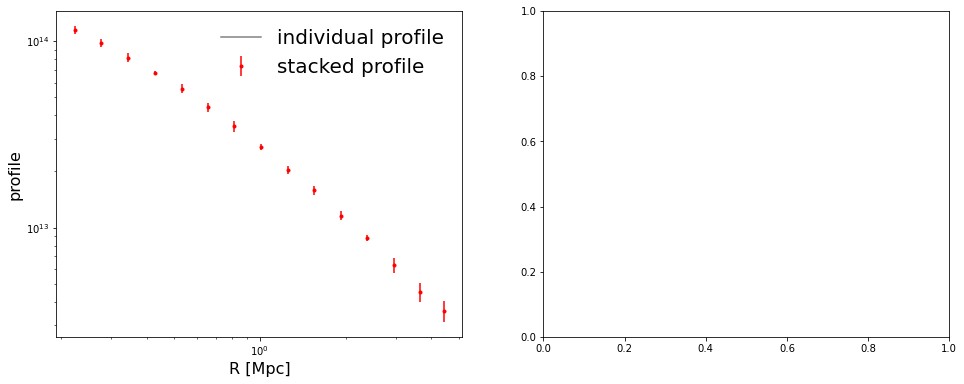

In [181]:
#plt.errorbar(profile_classical['radius'], profile_classical['gt'], profile_classical['gt_err'])
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
axes[0].plot([],[],c='grey', label='individual profile')    
axes[0].errorbar(profile['radius'], profile['gt'],profile['gt_err'], color='red', label='stacked profile', fmt='.')
axes[0].set_xlabel('R [Mpc]', fontsize=16)
axes[0].set_ylabel('profile', fontsize=16)
axes[0].legend(fontsize=20, frameon=False)
axes[0].semilogx()
axes[0].semilogy()

plt.show()

### Defining a model and a fitting procedure

we select the model to fit following the type of profile.

In [40]:
def model_data(r,logm):
    if stack.is_deltasigma == False:
        return model.predict_reduced_tangential_shear_z_distrib(r, logm, stack.average_z, stack.z_galaxy_list, moo)

    else:
        return model.predict_excess_surface_density(r, logm, stack.average_z, stack.z_galaxy_list,  0,  moo)

### Fitting a halo mass

we fit the Halo mass using `scipy` module.

In [41]:
param_p0 = [14.]
param_bounds = ([13. ], [16.])
logm_fit, cov_logm_fit = curve_fit(model_data, profile['radius'], profile['gt'], sigma = profile['gt_err'], bounds = param_bounds, p0 = param_p0)

AttributeError: 'StackingWeight' object has no attribute 'z_galaxy_list'

In [ ]:
m_fit = float(10**logm_fit)
err_m_fit = float(m_fit * np.sqrt(cov_logm_fit[0][0]) * np.log(10))

In [ ]:
print(f'Best fit mass for cluster 1 = {m_fit:.2e} +/- {err_m_fit:.2e} Msun')
print(f'Average mass = {np.mean(cluster_m):.2e} Msun')

In [ ]:
r = np.linspace(0.2,5,1000)
if deltasigma == False:
    y_fit = model.predict_reduced_tangential_shear_z_distrib(r, logm_fit, stack.average_z, stack.z_galaxy_list, moo)
    
else:
    y_fit = model.predict_excess_surface_density(r, logm_fit, stack.average_z, stack.z_galaxy_list, 0, moo)

In [ ]:
plt.figure(figsize=(8,6))
plt.tick_params(axis='both', which='major', labelsize=14)
plt.style.use('classic')

for i in range(stack.n_stacked_gt):
    
    plt.plot(stack.radial_axis_list[i],stack.gt_list[i],c='grey',alpha=0.1)
    
plt.plot([],[],c='grey', label='individual profile')
plt.errorbar(profile['radius'], profile['gt'],profile['gt_err'], color='red', label='stacked profile', fmt='.')
plt.plot(r,y_fit, label=r'$\rm{model\ with}\ M^{fit}_{200m} = %.2e M_\odot$'%(m_fit))
plt.xlabel('R [Mpc]', fontsize=16)
plt.ylabel('profile', fontsize=16)

plt.legend(fontsize=15, frameon=False, loc='best')
plt.semilogx()
plt.semilogy()
plt.xlim(0.2,5)
plt.show()